<a href="https://colab.research.google.com/github/oughtinc/ergo/blob/master/notebooks/el-paso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install --progress-bar off --quiet poetry
!pip install --progress-bar off --quiet git+https://github.com/oughtinc/ergo.git







  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done













ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 3.7.4.2 which is incompatible.


In [0]:
%load_ext google.colab.data_table

# Load questions

In [0]:
import ergo

Log into Metaculus:

In [0]:
metaculus = ergo.Metaculus(
    username="YOUR-USERNAME", 
    password="YOUR-PASSWORD",
    api_domain="pandemic"
)

Load questions for the El Paso series:

In [0]:
questions = metaculus.get_questions(cat="internal--el-paso")

In [7]:
ergo.MetaculusQuestion.to_dataframe(questions)

,id,title,resolve_time
0,4201,How many patients with Covid-19 in El Paso Cou...,2020-12-31 23:00:00
1,4204,How many patients with Covid-19 in El Paso Cou...,2020-12-31 23:00:00
2,4128,"When will El Paso County, Texas, experience it...",2020-12-31 23:01:00
3,4137,How many new infections will be reported in El...,2020-12-31 23:00:00
4,4152,What will the average number of reported daily...,2020-12-31 23:00:00
5,4153,What will the maximum number of in-hospital la...,2021-01-01 00:00:00
6,4154,What portion of in-hospital patients with Covi...,2020-12-31 23:00:00
7,4155,What portion of in-hospital cases in El Paso C...,2020-12-31 23:00:00
8,4170,What will the average number of reported daily...,2020-12-31 23:00:00
9,4185,What will the unemployment rate be in El Paso ...,2020-12-31 23:00:00


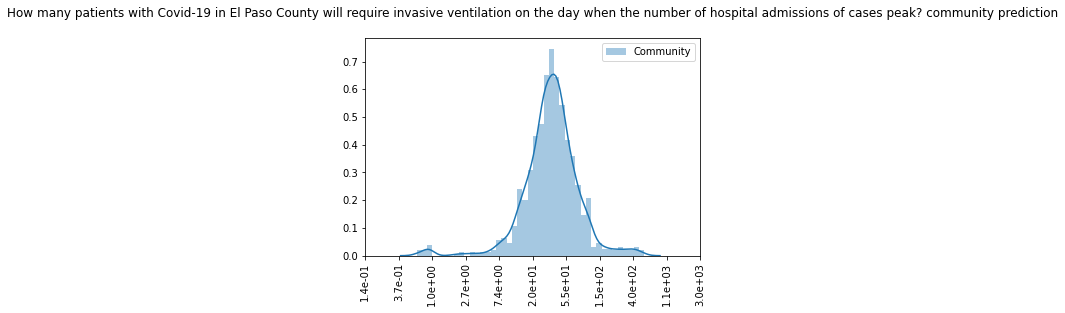

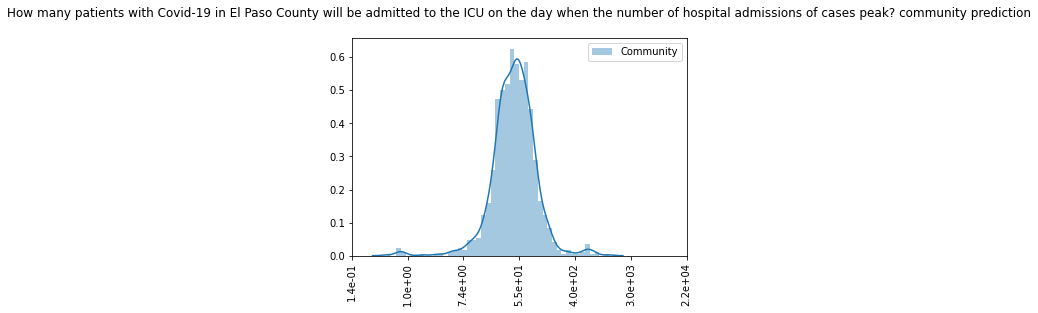

When will El Paso County, Texas, experience its first peak number of COVID infections?


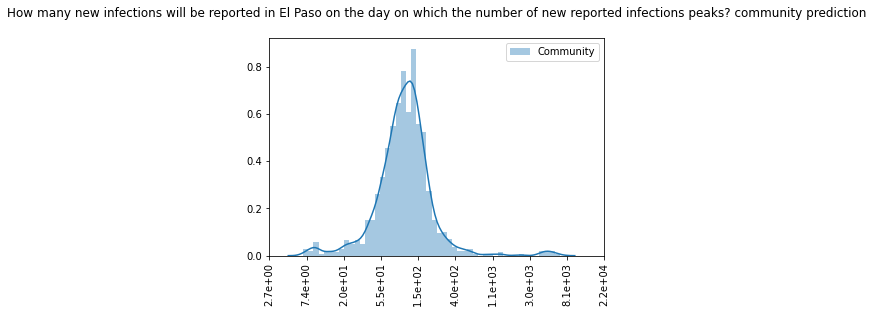

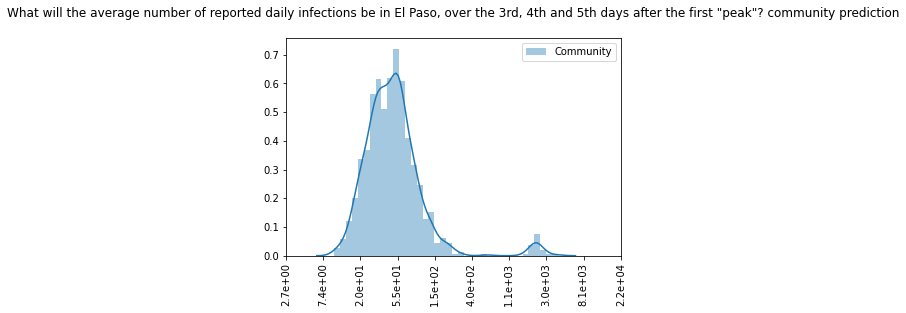

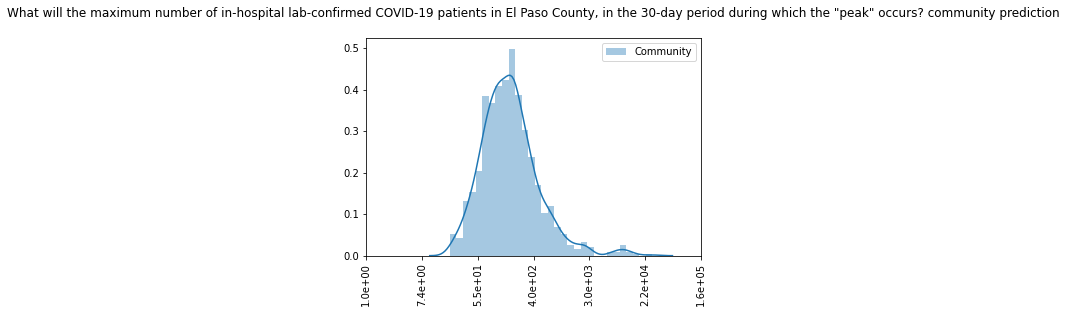

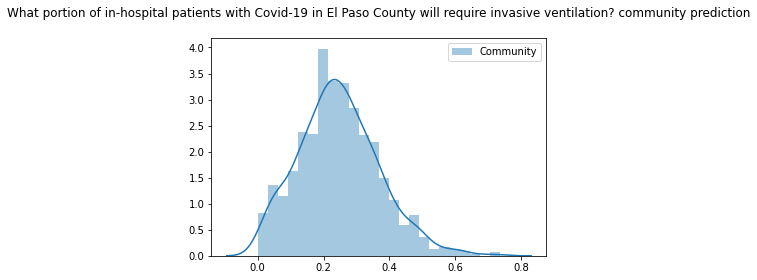

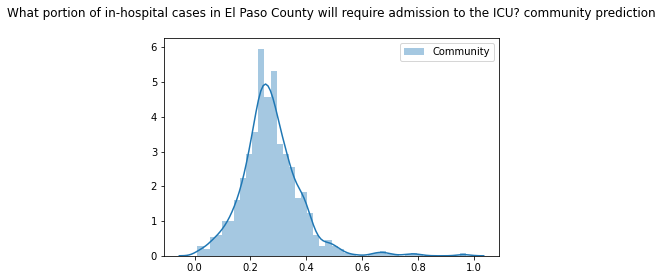

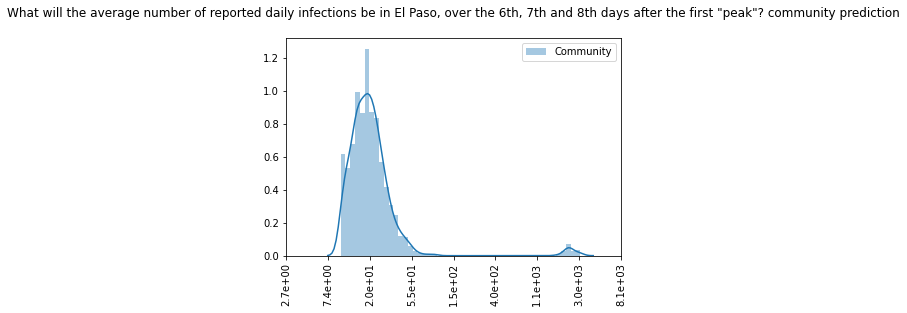

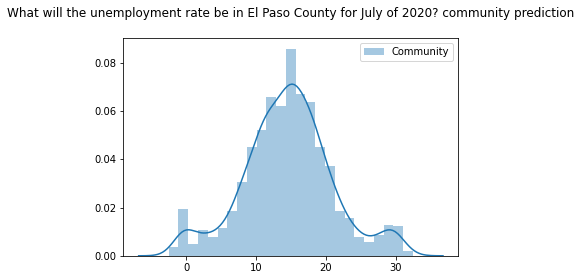

In [8]:
for question in questions:
    question.refresh_question()  # Load detailed question data
    if isinstance(question, ergo.metaculus.LinearDateQuestion):
        print(question)
    else:
        question.show_community_prediction()